<a href="https://colab.research.google.com/github/suhasbn/DS402/blob/main/DS402_Tutorial_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Coronavirus Case forcasting using LSTM in PyTorch 

This tutorial is an example of how you can use Recurrent Neural Networks on some real-world Time Series data with PyTorch. 

Time series data captures a series of data points recorded at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of sales a company makes.

In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when dealing with time series data.

Recurrent Neural Networks (LSTMs are one type of those) are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

# Novel Coronavirus (COVID-19)

The novel Coronavirus (Covid-19) has spread around the world very rapidly. At the time of this writing, [Worldometers.info](https://www.worldometers.info/coronavirus/) shows that there are more than *123,951,479* confirmed cases in more than *221* countries.

The top 4 worst-affected (by far) are USA, Brazil, India and Russia. Unfortunately, many cases are currently not reported due to:

- A person can get infected without even knowing (asymptomatic)
- Incorrect data reporting
- Not enough test kits
- The symptoms look a lot like the common flu

### How dangerous is this virus?

Except for the common statistics you might see cited on the news, there are some good and some bad news:

- The reproductive number which represents the average number of people to which a single infected person will transmit the virus is between 1.5 and 3.5 [(WHO's number on Mar. 22)](https://www.worldometers.info/coronavirus/#repro)

It means that we can witness some crazy exponential growth if appropriate measures are not put in place.

Let's get started!

In [ ]:
!pip install -Uq watermark # extension for printing date and time stamps

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy : 1.19.5
pandas: 1.1.5
torch : 1.8.0+cu101



In [ ]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Daily Cases Dataset

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country. [The dataset is available on GitHub](https://github.com/CSSEGISandData/COVID-19) and is updated regularly.

We're going to take the Time Series data only for confirmed cases (number of deaths and recovered cases are also available):

In [ ]:
 !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2021-03-22 13:21:18--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538037 (525K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>] 525.43K  --.-KB/s    in 0.02s   

2021-03-22 13:21:18 (23.5 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [538037/538037]



## Data exploration

Let's load the data and have a peek:

In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,55402,55420,55445,55473,55492,55514,55518,55540,55557,55575,55580,55604,55617,55646,55664,55680,55696,55707,55714,55733,55759,55770,55775,55827,55840,55847,55876,55876,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,88671,89776,90835,91987,93075,93850,94651,95726,96838,97909,99062,100246,101285,102306,103327,104313,105229,106215,107167,107931,108823,109674,110521,111301,112078,112897,113580,114209,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,109782,110049,110303,110513,110711,110894,111069,111247,111418,111600,111764,111917,112094,112279,112461,112622,112805,112960,113092,113255,113430,113593,113761,113948,114104,114234,114382,114543,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10352,10391,10427,10463,10503,10538,10555,10583,10610,10645,10672,10699,10712,10739,10775,10799,10822,10849,10866,10889,10908,10948,10976,10998,11019,11042,11069,11089,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20210,20261,20294,20329,20366,20381,20389,20400,20452,20478,20499,20519,20548,20584,20640,20695,20759,20782,20807,20854,20882,20923,20981,21026,21055,21086,21108,21114,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733


Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's start by getting rid of the first four columns:

In [ ]:
df = df.iloc[:, 4:]

In [ ]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,55402,55420,55445,55473,55492,55514,55518,55540,55557,55575,55580,55604,55617,55646,55664,55680,55696,55707,55714,55733,55759,55770,55775,55827,55840,55847,55876,55876,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,88671,89776,90835,91987,93075,93850,94651,95726,96838,97909,99062,100246,101285,102306,103327,104313,105229,106215,107167,107931,108823,109674,110521,111301,112078,112897,113580,114209,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,109782,110049,110303,110513,110711,110894,111069,111247,111418,111600,111764,111917,112094,112279,112461,112622,112805,112960,113092,113255,113430,113593,113761,113948,114104,114234,114382,114543,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10352,10391,10427,10463,10503,10538,10555,10583,10610,10645,10672,10699,10712,10739,10775,10799,10822,10849,10866,10889,10908,10948,10976,10998,11019,11042,11069,11089,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20210,20261,20294,20329,20366,20381,20389,20400,20452,20478,20499,20519,20548,20584,20640,20695,20759,20782,20807,20854,20882,20923,20981,21026,21055,21086,21108,21114,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733


Let's check for missing values:

In [ ]:
df.isnull().sum().sum()

0

Everything seems to be in place. Let's sum all rows, so we get the cumulative daily cases:

In [ ]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     557
2020-01-23     655
2020-01-24     941
2020-01-25    1433
2020-01-26    2118
dtype: int64

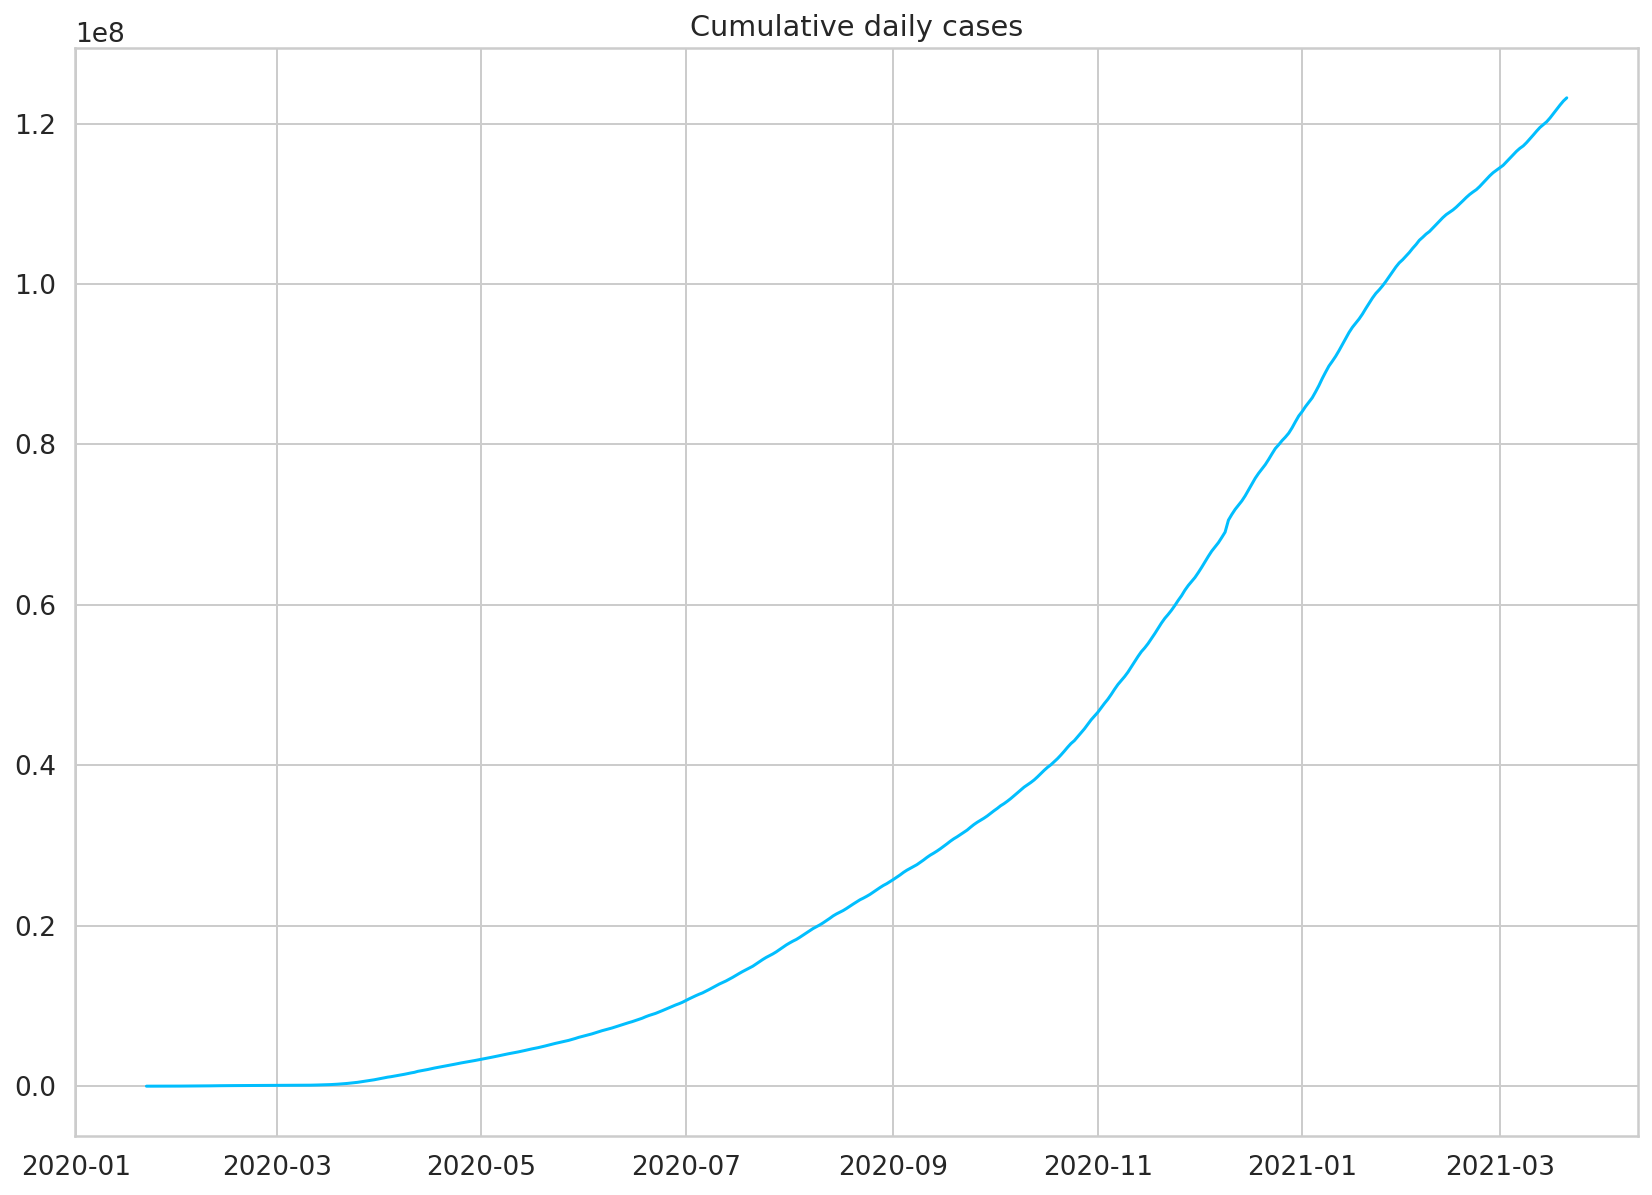

In [ ]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

In [ ]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    557
2020-01-23     98
2020-01-24    286
2020-01-25    492
2020-01-26    685
dtype: int64

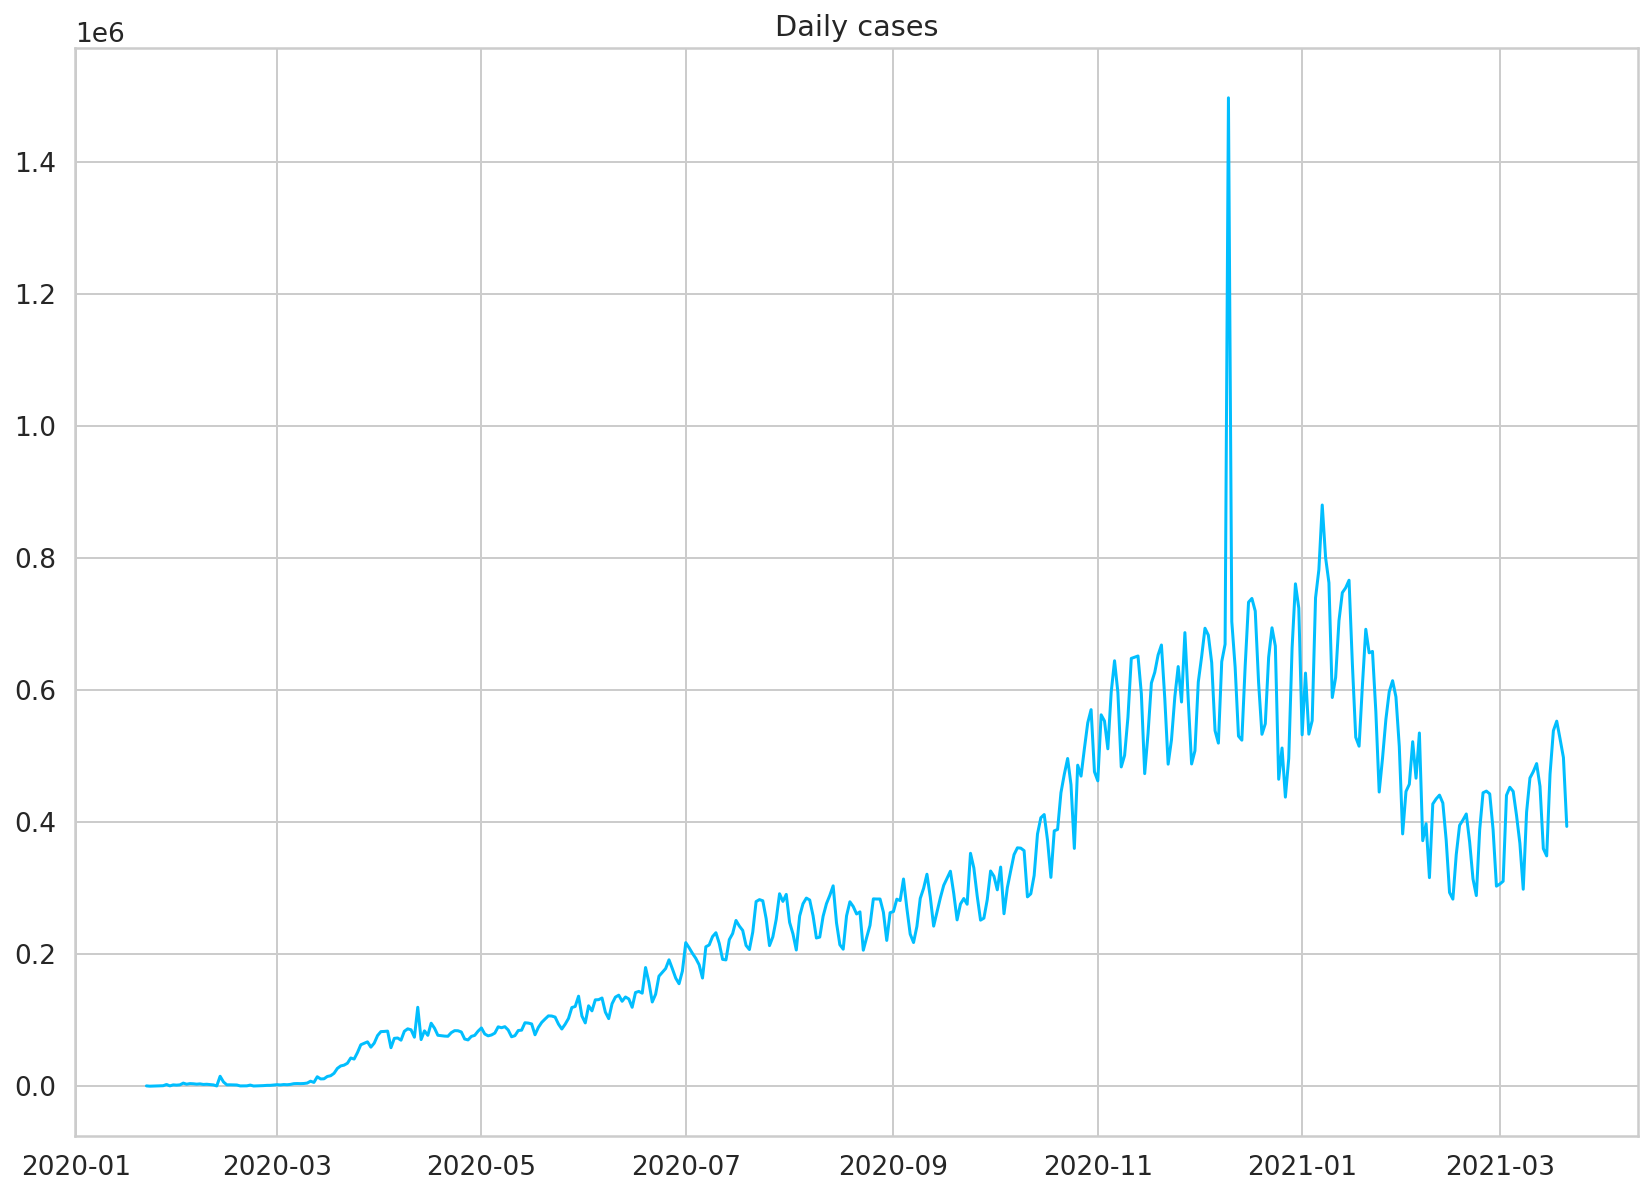

In [ ]:
plt.plot(daily_cases)
plt.title("Daily cases");

The huge spike (in the middle) is mostly due to a change of criteria for testing patients in China. This will certainly be a challenge for our model.

Let's check the amount of data we have:

In [ ]:
daily_cases.shape

(425,)

We have data for 425 days. Let's see what we can do with it!

## Preprocessing

We'll reserve the first 275 days for training and use the rest for testing:

In [ ]:
test_data_size = 150

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(275,)

We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 14 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [ ]:
X_train.shape

torch.Size([267, 7, 1])

In [ ]:
X_train[:2]

tensor([[[0.0010],
         [0.0000],
         [0.0004],
         [0.0008],
         [0.0012],
         [0.0015],
         [0.0054]],

        [[0.0000],
         [0.0004],
         [0.0008],
         [0.0012],
         [0.0015],
         [0.0054],
         [0.0010]]])

In [ ]:
y_train.shape

torch.Size([267, 1])

In [ ]:
y_train[:2]

tensor([[0.0010],
        [0.0042]])

In [ ]:
train_data[:10]

array([[0.00097109],
       [0.        ],
       [0.00039775],
       [0.00083357],
       [0.0012419 ],
       [0.00150424],
       [0.00540131],
       [0.0010388 ],
       [0.00416787],
       [0.00337238]])

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

In [ ]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Our `CoronaVirusPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [ ]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 30

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 1 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 1 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:

In [ ]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=256, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 58.272056579589844 test loss: 229.09841918945312
Epoch 1 train loss: 42.969058990478516 test loss: 201.46620178222656
Epoch 2 train loss: 29.93153953552246 test loss: 173.83924865722656
Epoch 3 train loss: 19.382352828979492 test loss: 141.8082275390625
Epoch 4 train loss: 15.750475883483887 test loss: 101.06322479248047
Epoch 5 train loss: 24.694499969482422 test loss: 68.70345306396484
Epoch 6 train loss: 18.970321655273438 test loss: 83.72748565673828
Epoch 7 train loss: 15.7551851272583 test loss: 101.67147064208984
Epoch 8 train loss: 15.484251022338867 test loss: 116.12223052978516
Epoch 9 train loss: 16.5414981842041 test loss: 126.254638671875
Epoch 10 train loss: 17.393524169921875 test loss: 132.38482666015625
Epoch 11 train loss: 17.922439575195312 test loss: 134.7346954345703
Epoch 12 train loss: 17.837779998779297 test loss: 134.56500244140625
Epoch 13 train loss: 17.640836715698242 test loss: 133.3955841064453
Epoch 14 train loss: 16.952014923095703 te

Let's have a look at the train and test loss:

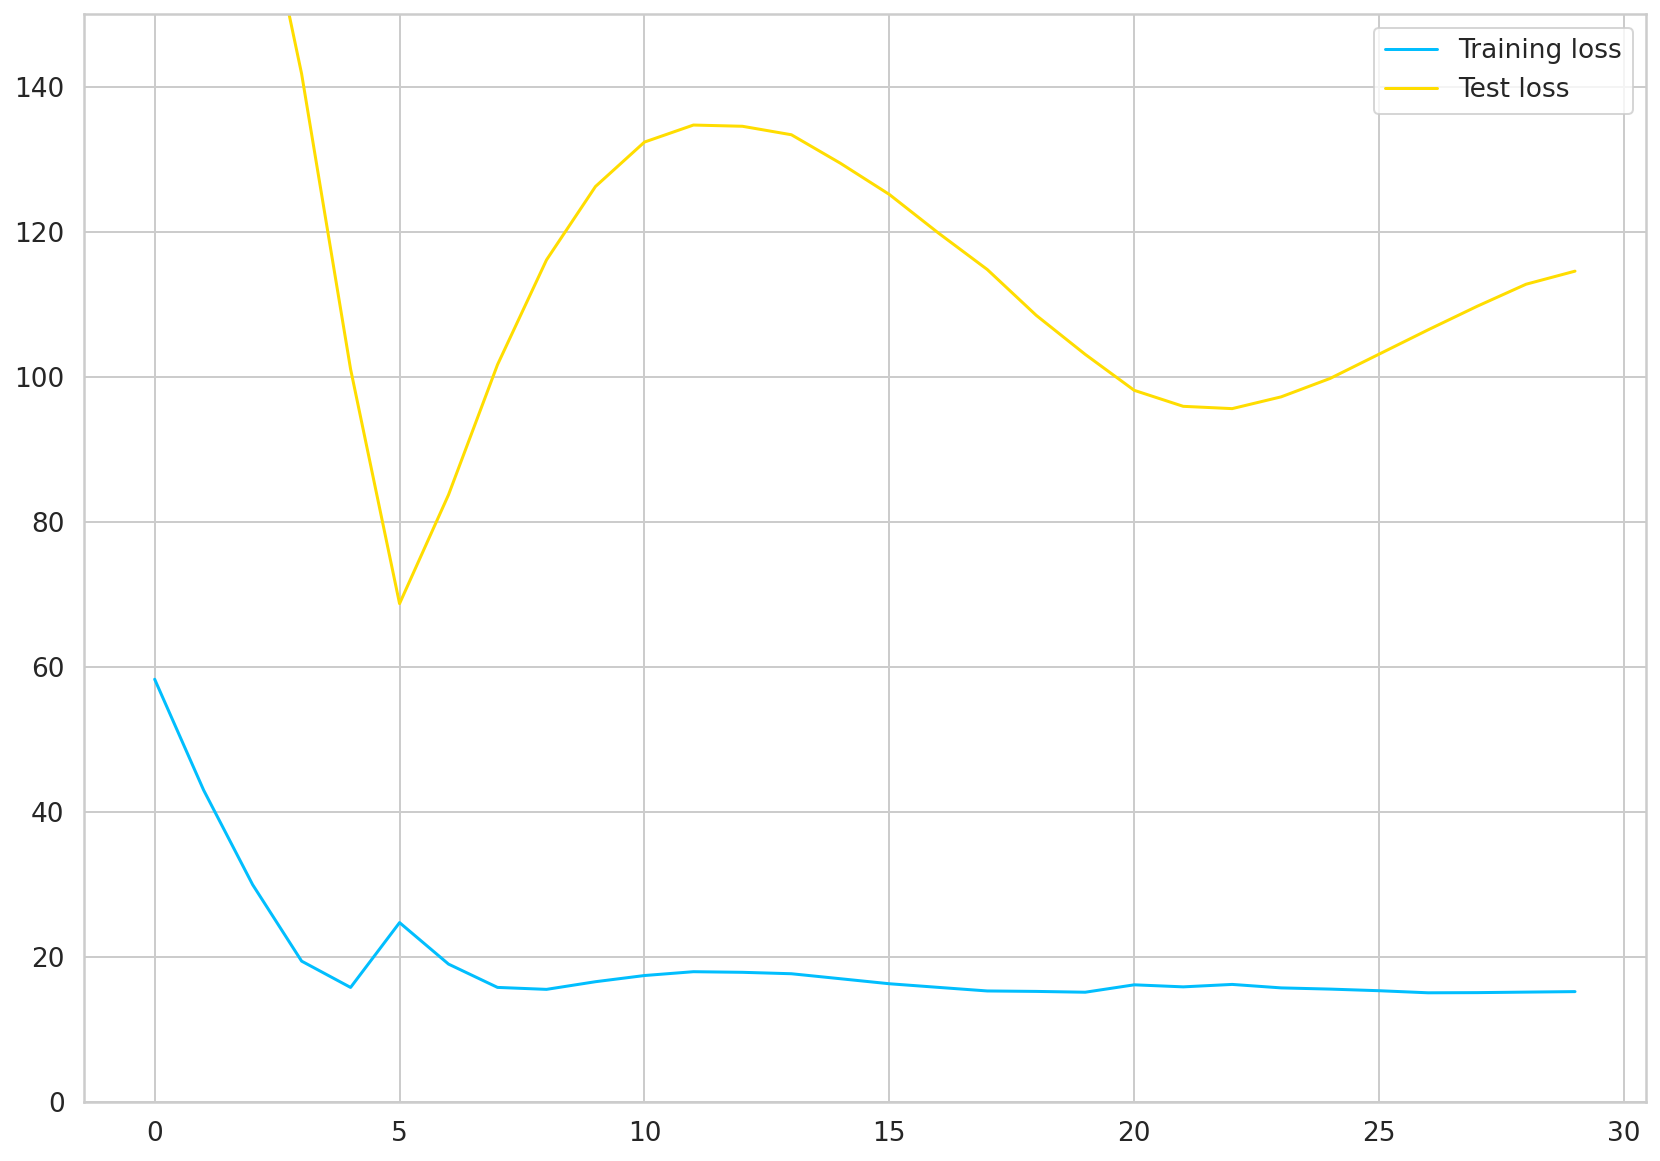

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 150))
plt.legend();

Our model's performance doesn't improve after 15 epochs or so. Recall that we have very little data. Maybe we shouldn't trust our model that much?

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Let's look at the results:

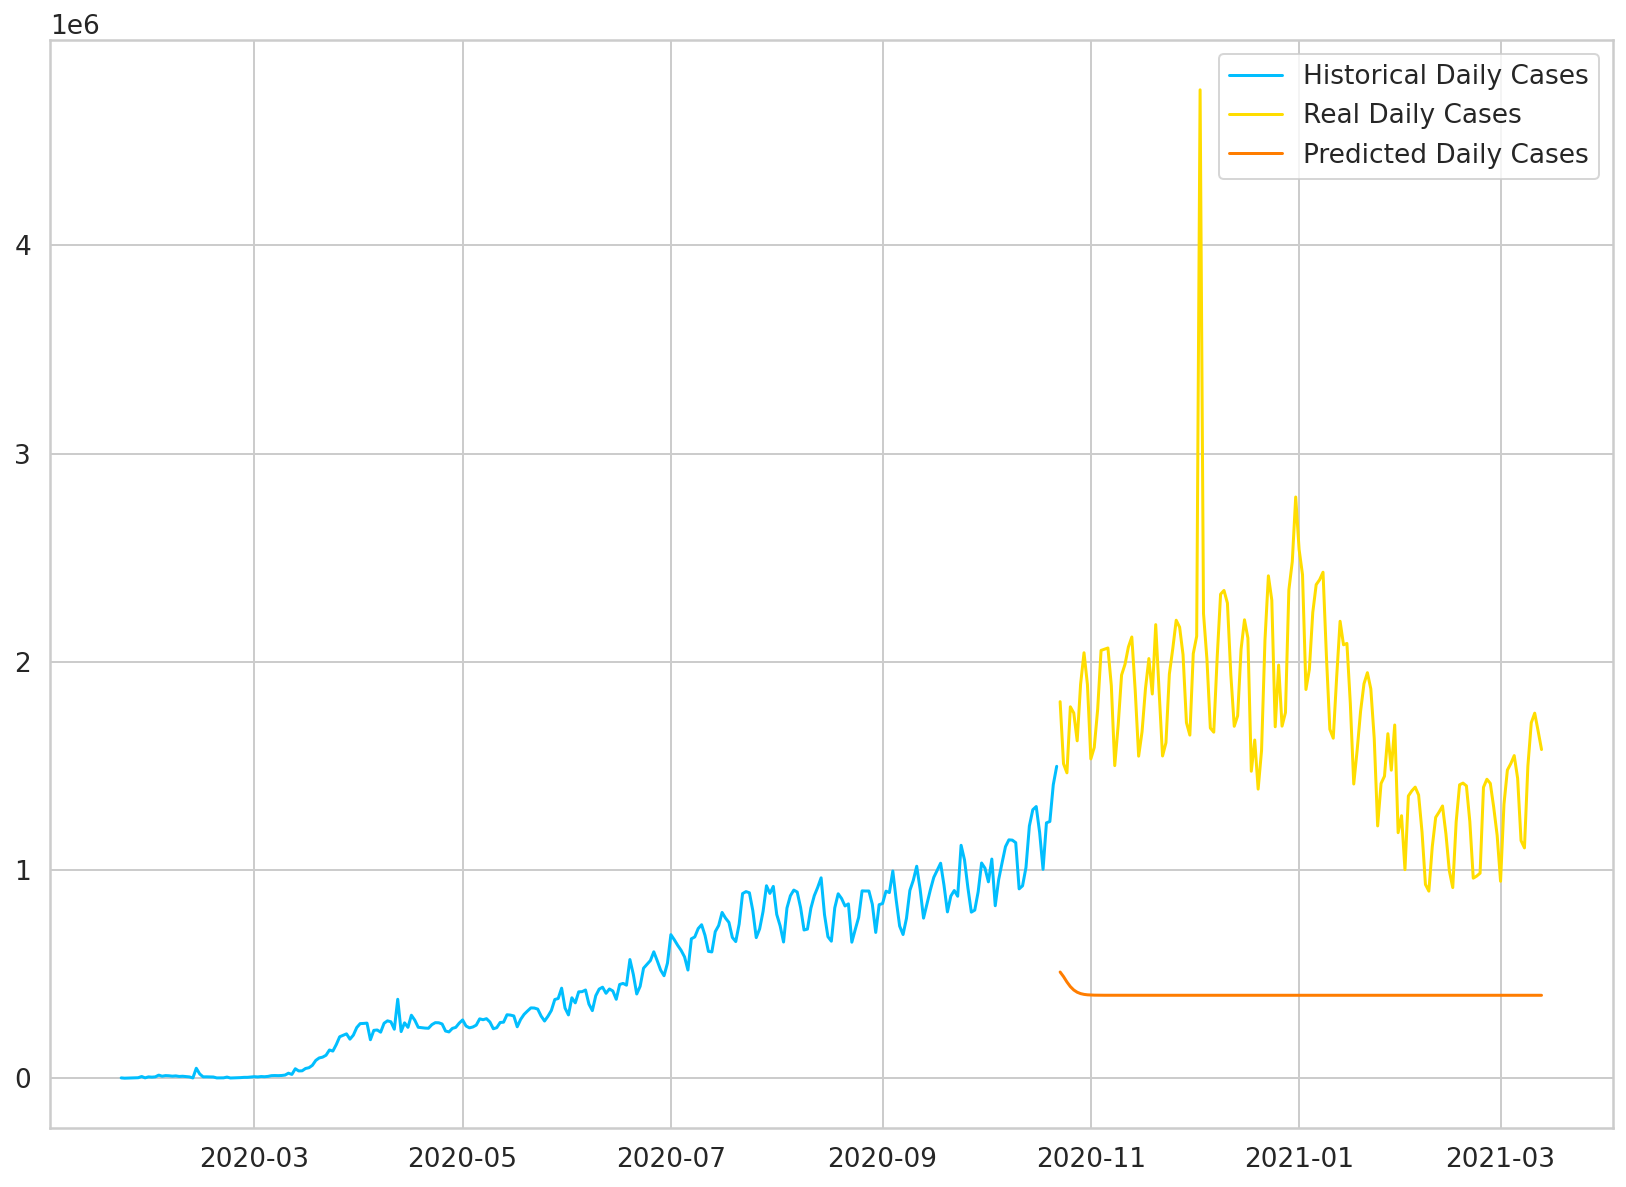

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

As expected, our model doesn't perform very well. That said, the predictions seem to be in the right ballpark (probably due to using the last data point as a strong predictor for the next).

## Use all data for training

Now, we'll use all available data to train the same model:

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(425, 1)

The preprocessing and training steps are the same:

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=256, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 48.32062530517578
Epoch 1 train loss: 35.851219177246094
Epoch 2 train loss: 25.585445404052734
Epoch 3 train loss: 17.460187911987305
Epoch 4 train loss: 16.09483528137207
Epoch 5 train loss: 21.769807815551758
Epoch 6 train loss: 17.68180274963379
Epoch 7 train loss: 15.41236686706543
Epoch 8 train loss: 15.410544395446777
Epoch 9 train loss: 16.216642379760742
Epoch 10 train loss: 16.765085220336914
Epoch 11 train loss: 16.921192169189453
Epoch 12 train loss: 17.01961326599121
Epoch 13 train loss: 16.574907302856445
Epoch 14 train loss: 15.994146347045898
Epoch 15 train loss: 15.763212203979492
Epoch 16 train loss: 15.096269607543945
Epoch 17 train loss: 15.306086540222168
Epoch 18 train loss: 15.3936128616333
Epoch 19 train loss: 15.523706436157227
Epoch 20 train loss: 15.793434143066406
Epoch 21 train loss: 15.8333101272583
Epoch 22 train loss: 15.638670921325684
Epoch 23 train loss: 15.391168594360352
Epoch 24 train loss: 15.002578735351562
Epoch 25 train loss

## Predicting future cases

We'll use our "fully trained" model to predict the confirmed cases for 21 days into the future:

In [ ]:
DAYS_TO_PREDICT = 21

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As before, we'll inverse the scaler transformation:

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [ ]:
daily_cases.index[-1]

Timestamp('2021-03-21 00:00:00')

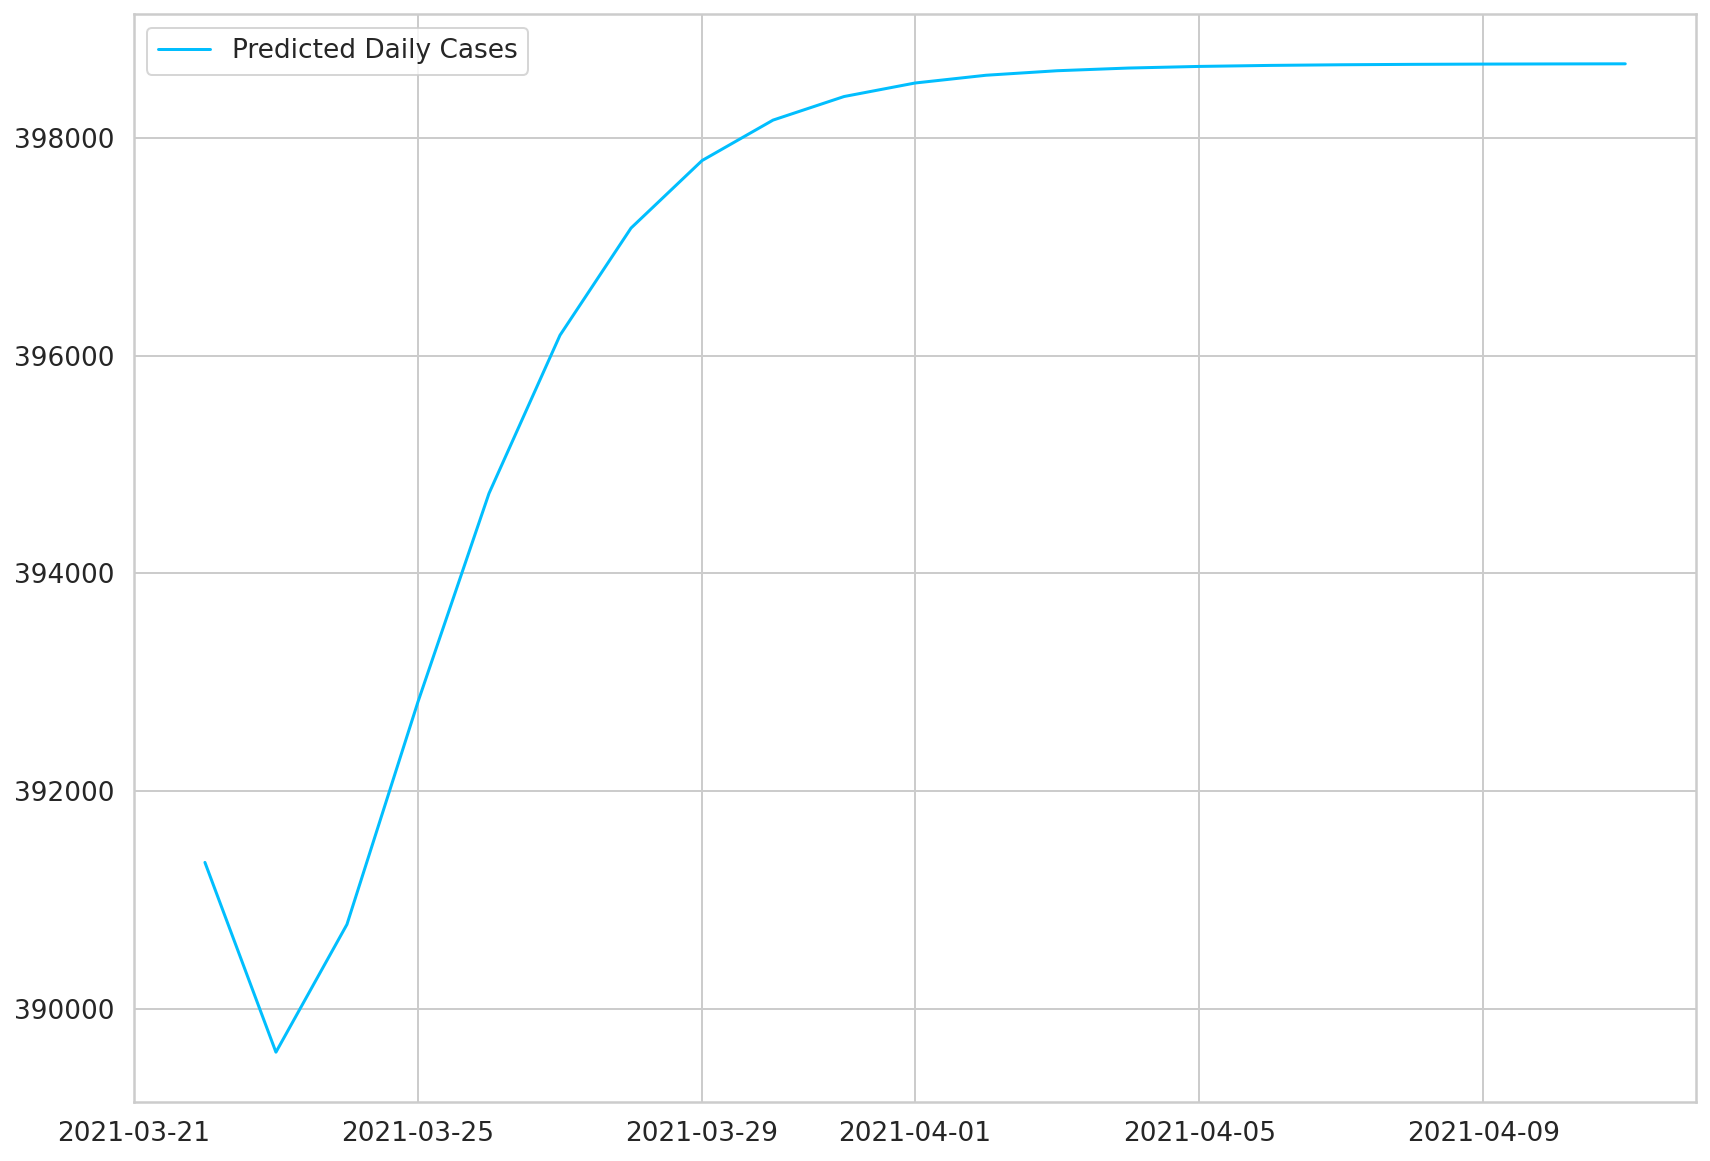

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Now we can use all the data to plot the results:

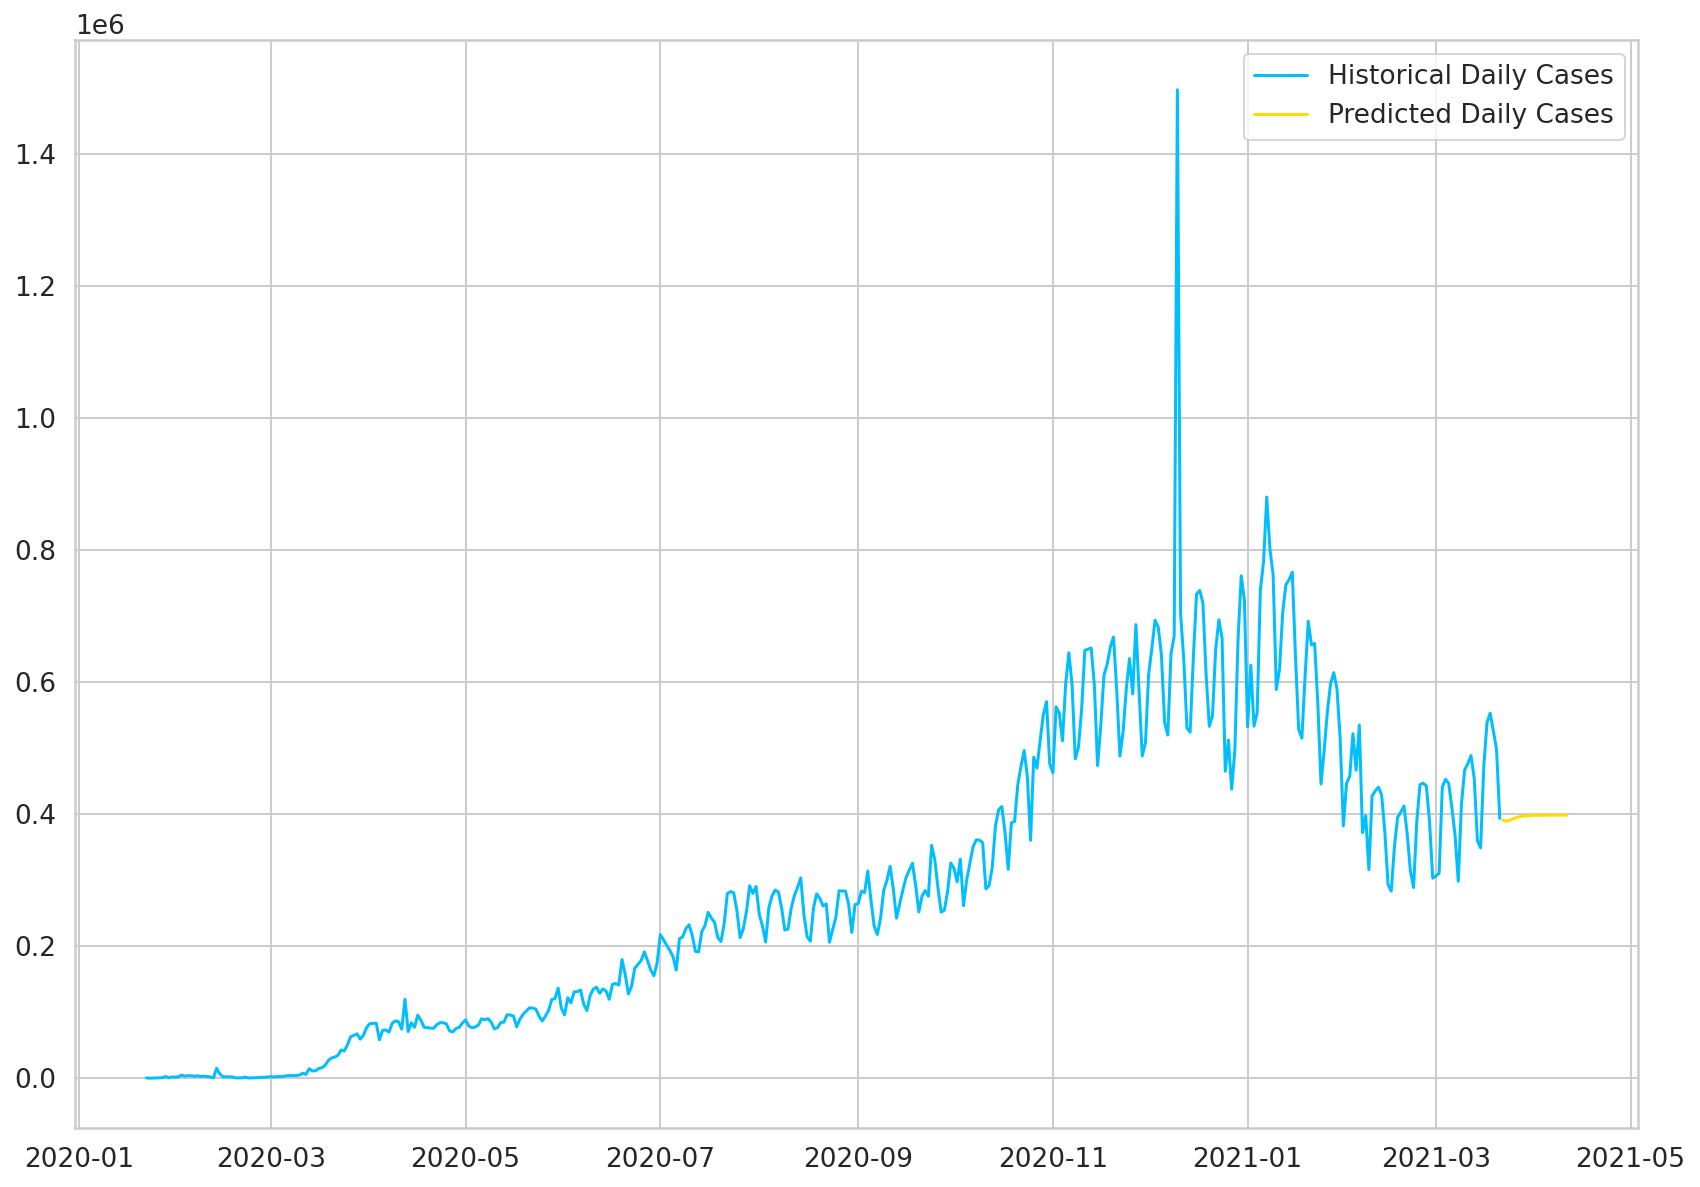

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Our model thinks that things will level off. Note that the more you go into the future, the more you shouldn't trust your model predictions.

## Conclusion

You learned how to use PyTorch to create a Recurrent Neural Network that works with Time Series data. The model performance is not that great, but this is expected, given the small amounts of data.

The problem of predicting daily Covid-19 cases is a hard one. We're amidst an outbreak, and there's more to be done. Hopefully, everything will be back to normal after some time.